In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imutils

In [2]:
class ImageGraph:
    
    class Node:

        def __init__(self, row, col, pix):
            self.row = row
            self.col = col
            self.pix = pix
            self.ptr = self
            self.int = 0
            self.size = 1

    def __init__(self, img, mode="photo", k = 1):
        
        if mode=="photo":
            self.img_pth = img
            self.img = np.array(Image.open(img).convert("L"), dtype=np.uint8)
        elif mode=="video":
            self.img = img
        else:
            RuntimeError("Mode of segmentation Undefined")

        [self.rows, self.cols] = self.img.shape
        self.size = self.rows * self.cols
        self.nodes = [[self.Node(i, j, self.img[i, j]) for j in range(self.cols)] for i in range(self.rows)]
        self.k = k
        self.edges = []

    def w(self, i1, j1, i2, j2):
        pix1 = int(self.img[i1, j1])
        pix2 = int(self.img[i2, j2])
        return abs(pix1 - pix2)

    def create_edges(self):

        for i in range(self.rows):
            for j in range(self.cols):
                if i != self.rows-1:
                    self.edges.append([self.w(i, j, i+1, j), [self.nodes[i][j], self.nodes[i+1][j]]])
                if j != self.cols-1:
                    self.edges.append([self.w(i, j, i, j+1), [self.nodes[i][j], self.nodes[i][j+1]]])

    def segment(self):

        self.create_edges()
        self.edges.sort(key=lambda x: x[0])

        for edge in self.edges:
            diff = edge[0]
            n1 = edge[1][0]
            n2 = edge[1][1]
            c1 = self.find(n1)
            c2 = self.find(n2)
            if c1 != c2:
                mint = min(c1.int + self.t(c1.size), c2.int + self.t(c2.size))
                if diff <= mint:
                    self.union(c1, c2, diff)

    def find(self, n):
        if n.ptr != n:
            n.ptr = self.find(n.ptr)
        return n.ptr

    def union(self, n1, n2, w):
        rootA, rootB = self.find(n1), self.find(n2)
        if rootA != rootB:
            rootA.ptr = rootB
            rootB.size += rootA.size
            rootB.int = w

    def t(self, size):
        threshold = self.k/size
        return threshold

    def color(self, i):
        B = i%256
        G = ((i-B)/256)%256
        R = ((i-B)/256**2)-G/256
        return np.array([R, B, G], dtype=np.uint8)

    def generate_segmentation(self):
        segmentation = np.zeros((self.rows, self.cols, 3))
        for i in range(self.rows):
            for j in range(self.cols):
                row = self.find(self.nodes[i][j]).row
                col = self.find(self.nodes[i][j]).col
                segmentation[i][j] = self.color(self.rows*row + col)
        segmentation = np.array(segmentation, dtype=np.uint8)
        return segmentation

    def plot_segmentation(self):
        plt.imshow(self.generate_segmentation())

    def save(self, file_name):
        segmentation = Image.fromarray(self.generate_segmentation())
        segmentation.save(file_name)

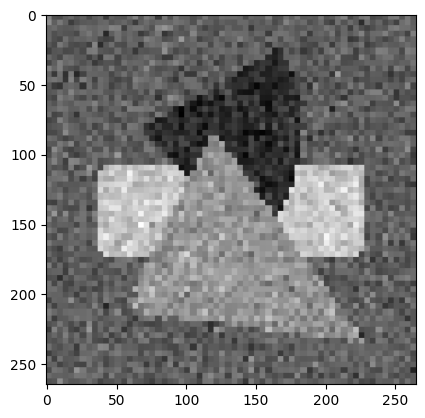

In [3]:
test_img = plt.imread("test.png")
plt.imshow(test_img)

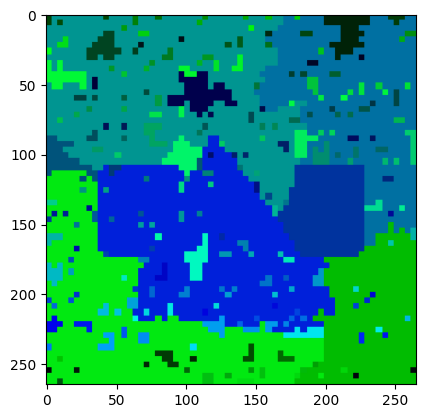

In [4]:
img = ImageGraph(img="test.png", mode="photo", k=10000)
img.segment()
img.plot_segmentation()

In [6]:
cap = cv2.VideoCapture(0)

while(True):

    ret, frame = cap.read()
    print(frame)
    # frame = imutils.resize(frame, width=300)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    gray = ImageGraph(img=gray, k=500, mode="video")
    gray.segment()
    
    cv2.imshow('frame', gray.generate_segmentation())

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

None


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
